In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'

print(f'PyTorch version: {torch.__version__}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

PyTorch version: 1.4.0
device: cpu


In [5]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
print('mnist_train: \n', mnist_train, '\n')
print('mnist_test: \n', mnist_test, '\n')
print('Done.')

mnist_train: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test: 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [6]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print('Done.')

Done.


### Define the MLP Model

In [8]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self, name='mlp', xdim=784, hdim=256, ydim=10):
        super(MultiLayerPerceptronClass, self).__init__()
        self.name = name
        self.xdim = xdim  # input dimension
        self.hdim = hdim  # hidden dimension
        self.ydim = ydim  # output dimension
        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)
        self.init_param() # initialize parameters
        
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp', xdim=784, hdim=256, ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(), lr=1e-3)
print ("Done.")

Done.


### Simple Forward Path of the MLP Model

In [20]:
x_numpy = np.random.rand(2, 784)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch)  # forward 명시해주는게 코드 읽을 때 편함. 최대한 forward 명시할 것
# y_torch = M(x_torch)  # M.forward 안해줘도 자동으로 돌아감
y_numpy = y_torch.detach().cpu().numpy()

print(f'x_numpy.shape: {x_numpy.shape}, x_numpy:\n', x_numpy)
print(f'x_torch.shape: {x_torch.shape}, x_torch:\n', x_torch)
print(f'y_torch.shape: {y_torch.shape}, y_torch:\n', y_torch)
print(f'y_numpy.shape: {y_numpy.shape}, y_numpy:\n', y_numpy)

x_numpy.shape: (2, 784), x_numpy:
 [[0.77696737 0.01770706 0.32752356 ... 0.16274686 0.10467255 0.59204009]
 [0.24748931 0.6546377  0.89122125 ... 0.08379181 0.68923563 0.07489886]]
x_torch.shape: torch.Size([2, 784]), x_torch:
 tensor([[0.7770, 0.0177, 0.3275,  ..., 0.1627, 0.1047, 0.5920],
        [0.2475, 0.6546, 0.8912,  ..., 0.0838, 0.6892, 0.0749]])
y_torch.shape: torch.Size([2, 10]), y_torch:
 tensor([[ 0.7672, -0.5249, -0.5443,  1.2864, -0.6853,  0.4241, -0.6154, -1.0840,
          0.4211,  0.6596],
        [-0.1008, -0.5959,  0.2235,  1.7850, -0.3799,  0.0875, -1.0897, -0.9124,
         -0.8170,  1.9855]], grad_fn=<AddmmBackward>)
y_numpy.shape: (2, 10), y_numpy:
 [[ 0.7671851  -0.52489775 -0.5443175   1.2864432  -0.6852926   0.42408165
  -0.61541295 -1.083994    0.42110232  0.6596349 ]
 [-0.10079768 -0.595877    0.2234876   1.7850308  -0.3798806   0.08748034
  -1.0897478  -0.9123598  -0.81698096  1.9855044 ]]


### Check Parameters

In [22]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print(f'{p_idx} name: {param_name} shape: {param_numpy.shape}')
    print(f'    value: {param_numpy.reshape(-1)[:5]}')
print("Total number of parameters:[%s]."%(format(n_param,',d')))

0 name: lin_1.weight shape: (256, 784)
    value: [ 0.027 -0.063 -0.024 -0.009  0.034]
1 name: lin_1.bias shape: (256,)
    value: [0. 0. 0. 0. 0.]
2 name: lin_2.weight shape: (10, 256)
    value: [ 0.157 -0.081  0.056 -0.031  0.111]
3 name: lin_2.bias shape: (10,)
    value: [0. 0. 0. 0. 0.]
Total number of parameters:[203,530].


## Evaluation Function

In [23]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        model.eval()
        n_total, n_correct = 0, 0
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 28*28).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = n_correct / n_total
        model.train()
    return val_accr
print('Done')

Done


## Initial Evaluation

In [30]:
M.init_param() # initialize parameters
train_accr = func_eval(M,train_iter,device)
test_accr = func_eval(M,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.091] test_accr:[0.089].


## Train

In [31]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device)
        test_accr = func_eval(M,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")    

Start training.
epoch:[0] loss:[0.382] train_accr:[0.941] test_accr:[0.939].
epoch:[1] loss:[0.172] train_accr:[0.964] test_accr:[0.960].
epoch:[2] loss:[0.120] train_accr:[0.974] test_accr:[0.967].
epoch:[3] loss:[0.091] train_accr:[0.981] test_accr:[0.973].
epoch:[4] loss:[0.072] train_accr:[0.984] test_accr:[0.974].
epoch:[5] loss:[0.059] train_accr:[0.988] test_accr:[0.976].
epoch:[6] loss:[0.049] train_accr:[0.989] test_accr:[0.978].
epoch:[7] loss:[0.041] train_accr:[0.992] test_accr:[0.978].
epoch:[8] loss:[0.034] train_accr:[0.994] test_accr:[0.979].
epoch:[9] loss:[0.029] train_accr:[0.995] test_accr:[0.980].
Done


## Test

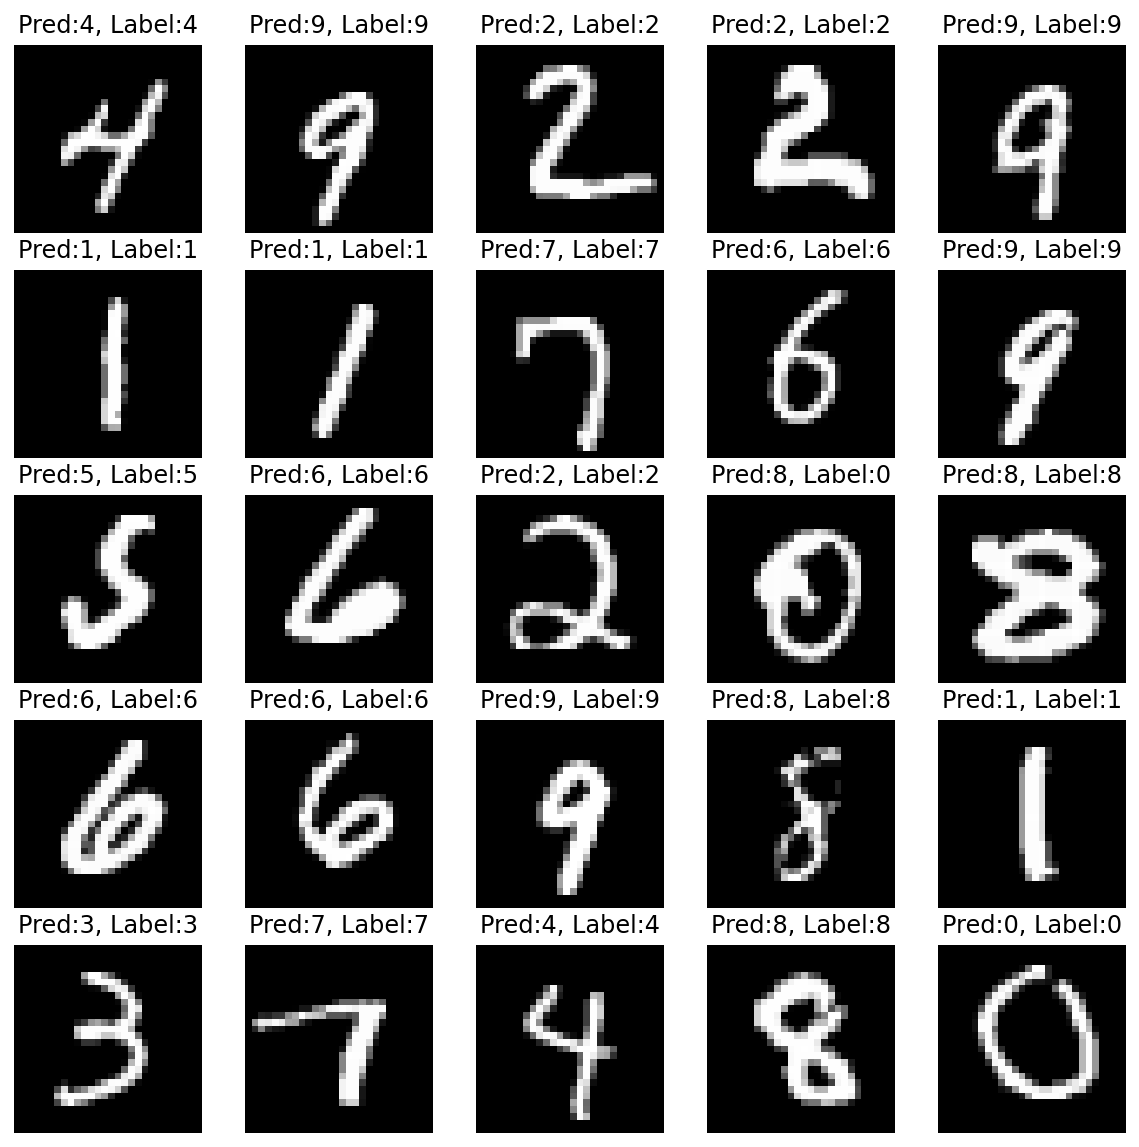

Done


In [33]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")